# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-2.186196,False,-3.169900
1,-0.879451,False,-0.600469
2,-0.170136,False,-0.428464
3,-3.128620,False,-1.000610
4,-0.040785,False,-0.081651
...,...,...,...
995,-0.800516,True,5.019058
996,-0.617456,False,-0.518607
997,-0.974641,False,-0.489228
998,-1.920336,False,-1.561214


<AxesSubplot: xlabel='v0'>

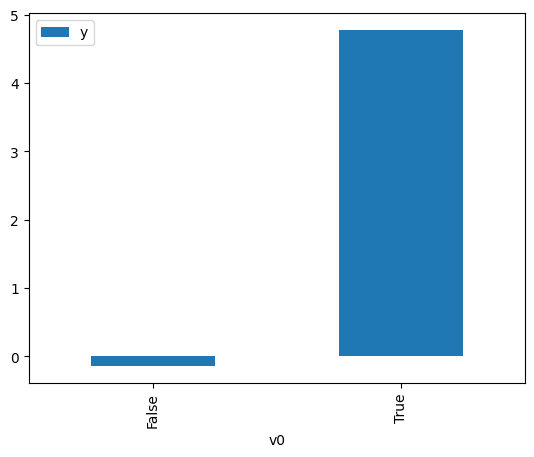

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

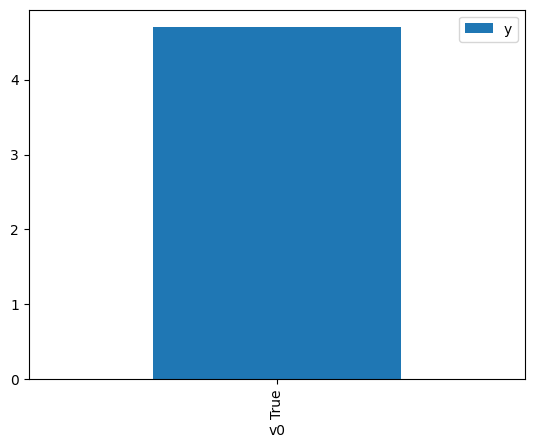

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.008004,False,-1.425509,0.489139,2.044410
1,0.373292,False,-1.679975,0.302732,3.303250
2,-1.971838,False,-3.283868,0.982534,1.017777
3,-0.970502,False,-0.970409,0.875765,1.141858
4,-0.899085,False,0.565383,0.858732,1.164508
...,...,...,...,...,...
995,-1.214374,False,-2.254417,0.921199,1.085541
996,1.890352,False,1.392968,0.018326,54.567895
997,0.358897,False,0.351109,0.309072,3.235495
998,-1.879920,False,-0.089048,0.978942,1.021511


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.243669,True,3.185726,0.074501,13.422622
1,0.391810,True,3.711468,0.705313,1.417809
2,2.372207,True,8.228056,0.993176,1.006871
3,-2.160767,True,3.374433,0.011871,84.240094
4,-1.144618,True,4.707580,0.089964,11.115523
...,...,...,...,...,...
995,-0.772471,True,4.768812,0.176219,5.674762
996,-0.246116,True,4.346200,0.389258,2.568990
997,-1.119818,True,3.413801,0.094265,10.608344
998,0.120525,True,5.696036,0.576896,1.733416


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              6043.
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                        0.00
Time:                        16:55:11   Log-Likelihood:                         -1401.3
No. Observations:                1000   AIC:                                      2807.
Df Residuals:                     998   BIC:                                      2816.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6291      0.030     20.785      0.000       0.570       0.688
x2             5.0000      0.050     99.290      0.000       4.901       5.099
==============================================================================
Omnibus:                        9.481   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.336
Skew:                          -0.175   Prob(JB):                      0.00570
Kurtosis:                       3.354   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""